In [29]:
from DataManagement.data_manager import DataManager
from DataManagement.coin_data import CoinData
from TransferEntropy.transfer_entropy import get_transfer_entropy
from constants import ATR_ABNORMALITY_COLUMN
from tqdm import tqdm
# libs
import pandas as pd
import numpy as np

# plotting
import seaborn as sn
import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = (70,30)

coin_symbol_list = ["BTCUSDT", "ETHUSDT", "ADAUSDT", "LTCUSDT"]
feature = "close"
kline_size = "1h"
main_coin_symbol = "BTCUSDT"
transfer_entropy_lookback = 2
suptitle_fontsize = 40
font_scale = 3
candle_size = "1d"
num_samples = 1440 # 60*24

In [30]:
data_manager = DataManager()
        # self.transfer_entropy = TransferEntropy(lookback=transfer_entropy_lookback, window_size=num_samples)

main_1d_df = data_manager.get_historical_data_CoinData(main_coin_symbol, kline_size="1d").df
coin_data_list = [data_manager.get_historical_data_CoinData(coin_symbol, kline_size="1m") for coin_symbol in coin_symbol_list]
# main_1h_df = data_manager.get_historical_data_CoinData(main_coin_symbol, kline_size="1h").df
main_abnormal_timestamp_list = main_1d_df[main_1d_df[ATR_ABNORMALITY_COLUMN] == 1].index

In [31]:
def join_dataframes(coin_data_list, shift):
    df = pd.DataFrame(index=coin_data_list[0].df.index)

    for coin_data in coin_data_list:
        df = df.join(coin_data.df.shift(shift)[feature], how="outer", rsuffix=f"_{coin_data.coin_symbol}", on="timestamp")

    df.rename(columns={"close_pct":f"close_pct_{coin_data_list[0].coin_symbol}"}, inplace=True)    
    df.dropna(inplace=True)
    df.drop(columns=["timestamp"])
    df.set_index("timestamp", inplace=True)
    return df

In [32]:
raw_df = join_dataframes(coin_data_list=coin_data_list, shift=0)

In [33]:
raw_df

,close,close_ETHUSDT,close_ADAUSDT,close_LTCUSDT
timestamp,,,,
2018-04-17 04:02:00,8028.01,507.41,0.27000,130.31
2018-04-17 04:03:00,8031.30,507.41,0.26108,130.44
2018-04-17 04:04:00,8032.99,507.60,0.26666,130.20
2018-04-17 04:05:00,8030.03,507.60,0.26666,130.19
2018-04-17 04:06:00,8033.36,507.59,0.26995,130.22
...,...,...,...,...
2021-06-30 10:39:00,34843.37,2137.59,1.33850,140.87
2021-06-30 10:40:00,34772.46,2132.66,1.33660,140.42
2021-06-30 10:41:00,34741.00,2131.88,1.33580,140.33


In [34]:
# from sklearn.preprocessing import MinMaxScaler
# x = df.values #returns a numpy array
# min_max_scaler = MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# df = pd.DataFrame(x_scaled, columns=df.columns)

In [35]:
# df.dropna(how="any", inplace=True)
# # df = df.resample('15min')
# resampled_list = df.resample("15min")
# df = resampled_list.median()
# for timestamp, temp_df in resampled_list:
#     df.loc[timestamp].sub(temp_df.mean(axis=0))

# # df = df.pct_change()
# df.dropna(how="any", inplace=True)
# # df = data_manager.add_noise_to_df(df)
# # df = df.sub(df.mean(axis=0))

In [36]:
df = raw_df["2021-01-01":].resample("5min").median()

In [37]:
df

,close,close_ETHUSDT,close_ADAUSDT,close_LTCUSDT
timestamp,,,,
2021-01-01 00:00:00,28982.69,737.430,0.18113,124.59
2021-01-01 00:05:00,28934.84,735.000,0.17978,124.35
2021-01-01 00:10:00,28824.35,732.150,0.17888,123.76
2021-01-01 00:15:00,28810.00,731.610,0.17964,123.48
2021-01-01 00:20:00,28796.29,730.660,0.17923,123.29
...,...,...,...,...
2021-06-30 10:20:00,34729.98,2127.100,1.33600,140.51
2021-06-30 10:25:00,34803.06,2130.640,1.33980,140.65
2021-06-30 10:30:00,34776.45,2131.380,1.33730,140.69


In [ ]:
df.describe()

,close,close_ETHUSDT,close_ADAUSDT,close_LTCUSDT
count,51850.000000,51850.000000,51850.000000,51850.000000
mean,45841.015095,2062.488879,1.120034,198.900507
std,10020.949339,703.907306,0.478692,57.696418
min,28767.580000,717.640000,0.169330,105.850000
25%,36183.572500,1605.630000,0.890013,157.650000
50%,47137.225000,1915.255000,1.206620,184.150000
75%,55843.362500,2453.457500,1.423297,225.200000
max,64615.460000,4360.040000,2.457400,411.600000


In [42]:
df = data_manager.add_noise_to_df(df, mu = 0, sigma = 10)

In [43]:
num_cols = len(df.columns)
n = len(df)
L = 1
result = np.ones(shape=(num_cols, num_cols))
for i, coli in enumerate(df.columns):
    for j, colj in enumerate(df.columns): 
        arr1 = df[coli].to_numpy()
        arr2 = df[colj].to_numpy()
        entropy_value = get_transfer_entropy(np.array([arr1[0:n-L], arr1[1:n]]), np.array([arr2[0:n-1], arr2[1:n]]))
        print(entropy_value)
        result[i, j] = entropy_value

result

nan
nan
nan
nan
nan


/Users/guyvandam/miniforge3/envs/tensorflow/lib/python3.8/site-packages/seaborn/matrix.py:194: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/guyvandam/miniforge3/envs/tensorflow/lib/python3.8/site-packages/seaborn/matrix.py:199: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


<AxesSubplot:>

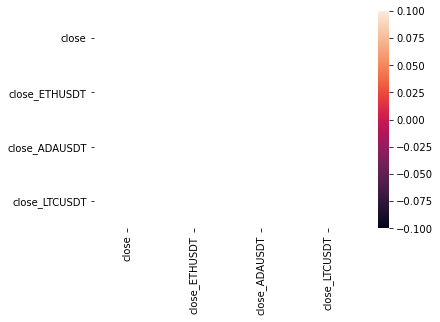

In [ ]:
result = pd.DataFrame(data=result, columns=df.columns, index=df.columns)
sn.heatmap(result, annot=True)